<a href="https://colab.research.google.com/github/albalopezdevesa/APRENDIZAJE_AUTOMATICO_23_24/blob/main/AA_PRACTICA3_GRUPO_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **REDES NEURONALES CONVOLUCIONALES**

**GRUPO 3**

Integrantes: Lucia Casas Sierra, Alba López Devesa, Paula Redondo Sastre

# Introducción
En esta práctica, nos encontramos frente al desafío de crear un modelo de Red de Neuronas Convolucionales que sea capaz de reconocer y clasificar imágenes en 100 categorías. Este modelo será definido, configurado, entrenado, evaluado y mejorado para posteriormente usarlo para hacer predicciones.
Con este propósito, se llevará a cabo la creación de un modelo en la biblioteca Keras, empleando el conjunto de datos CIFAR-100.


Lo primero que vamos a hacer es importar todo lo necesario para que nuestro modelo se ejecute.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from google.colab import files
import tarfile
import pickle
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, PReLU
from tensorflow.keras import regularizers
import keras
from keras.callbacks import Callback

## Importación de imágenes
Este conjunto de datos tiene 100 clases que contienen 600 imágenes cada una. Hay 500 imágenes de entrenamiento y 100 imágenes de prueba por clase. Las 100 clases del CIFAR-100 se agrupan en 20 superclases. Cada imagen viene con una etiqueta "fina" (la clase a la que pertenece) y una etiqueta "gruesa" (la superclase a la que pertenece).

Para importar el conjunto de imágenes, primero se tendrán que descargar del siguiente link:
https://www.cs.toronto.edu/~kriz/cifar.html

Para poder trabajar con ellas más adelante, tenemos que asegurarnos de que están en formato de 32x32 píxeles y que las etiquetas estén bien vinculadas a su respectiva imagen.

Saving cifar-100-python.tar.gz to cifar-100-python.tar.gz
Forma de train_image antes de la corrección: (50000, 3072)
Forma de test_image antes de la corrección: (10000, 3072)
Forma de train_image después de la corrección: (50000, 32, 32, 3)
Forma de test_image después de la corrección: (10000, 32, 32, 3)
Forma de train_fine_labels: 50000
Forma de test_fine_labels: 10000


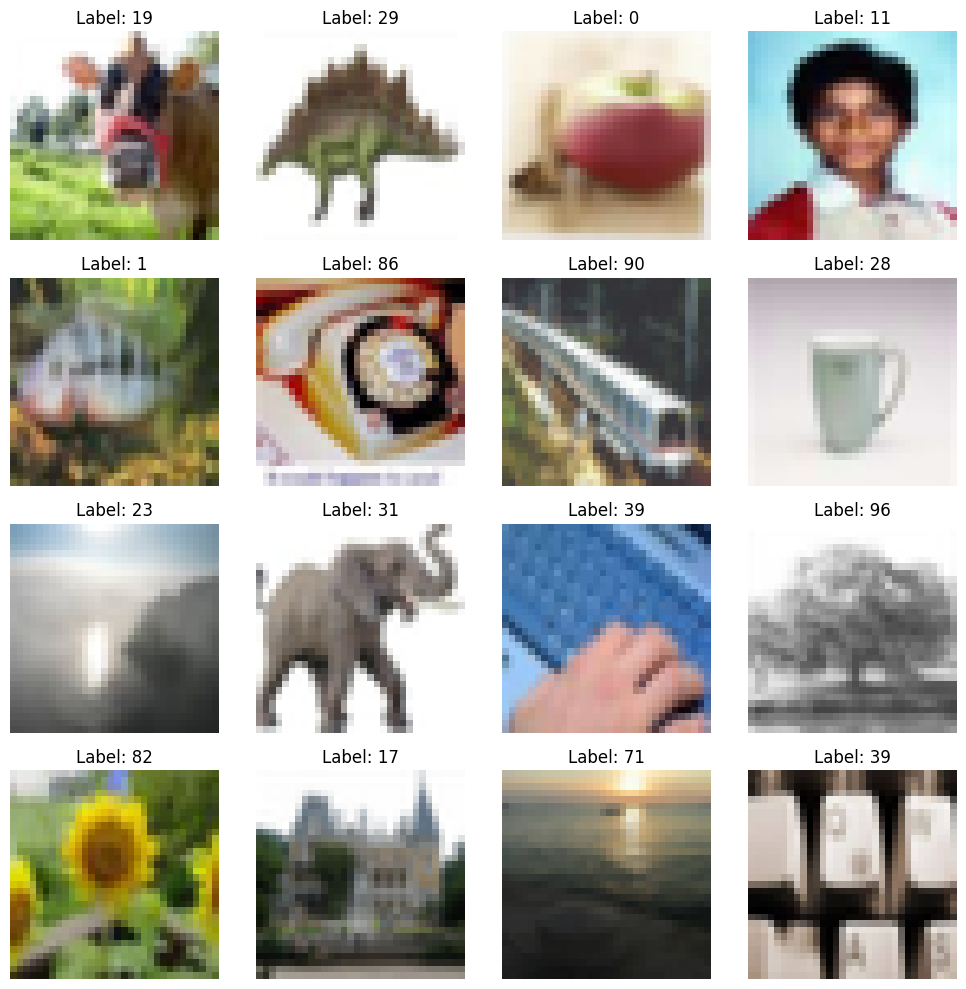

In [ ]:
# Subir el archivo CIFAR-100 a Google Colab
uploaded = files.upload()

# Nombre del archivo subido
file_name = "cifar-100-python.tar.gz"

# Extraer los archivos
with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()

# Nombre del archivo de datos de entrenamiento (puedes tener varios para entrenamiento y prueba)
train_file = "cifar-100-python/train"
test_file = "cifar-100-python/test"

# Cargar datos de entrenamiento
with open(train_file, "rb") as f:
    train_data = pickle.load(f, encoding="bytes")

# Cargar datos de test
with open(test_file, "rb") as f:
    test_data = pickle.load(f, encoding="bytes")

# Acceder a las imágenes y etiquetas
train_images = train_data[b'data']
train_fine_labels = train_data[b'fine_labels']
test_images = test_data[b'data']
test_fine_labels = test_data[b'fine_labels']

# Verificar la forma de las imágenes
print("Forma de train_image antes de la corrección:", train_images.shape)
print("Forma de test_image antes de la corrección:", test_images.shape)

# Corregir la forma de las imágenes
train_images = train_images.reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))
test_images = test_images.reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))

# Verificar la forma corregida
print("Forma de train_image después de la corrección:", train_images.shape)
print("Forma de test_image después de la corrección:", test_images.shape)

# Imprimir la forma de las etiquetas
print("Forma de train_fine_labels:", len(train_fine_labels))
print("Forma de test_fine_labels:", len(test_fine_labels))

# Mostramos algunas imágenes para ver cómo salen
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(train_images[i])
    plt.title(f'Label: {train_fine_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Ingeniería de características

### Redimensionamiento de las imágenes

Cuando aumentamos el tamaño de las imágenes en el contexto de una red neuronal convolucional, estamos realizando un proceso conocido como escalado. Esto puede ser necesario por diversas razones, como aumentar la resolución de las imágenes de entrada, realizar detección en múltiples escalas o preparar datos para su presentación visual. La interpolación se utiliza durante el escalado para llenar los espacios entre los píxeles originales y generar una imagen más grande. Esto es necesario pues al aumentar el tamaño de la imagen de entrada sin agregar información adicional, la cantidad de píxeles por unidad de longitud disminuiría. La interpolación ayuda a mantener una tasa de muestreo adecuada, evitando pérdida de información y manteniendo la coherencia con la red entrenada.

El método de interpolación cúbica suele producir resultados más suaves y precisos en comparación con otros métodos de interpolación más simples, como la interpolación bilineal.

Como se explica más abajo en el apartado de Pruebas, hemos probado a aumentar las imágenes a 64x64. De esta manera se obtiene una precisión muy parecida a la que hemos conseguido con 48x48, pero el tiempo que tarda en ejecutar es mucho mayor y por lo tanto menos eficiente. Por lo tanto, se concluye que el tamaño de 48x48 es más óptimo y por eso es el que utilizamos en el modelo final.











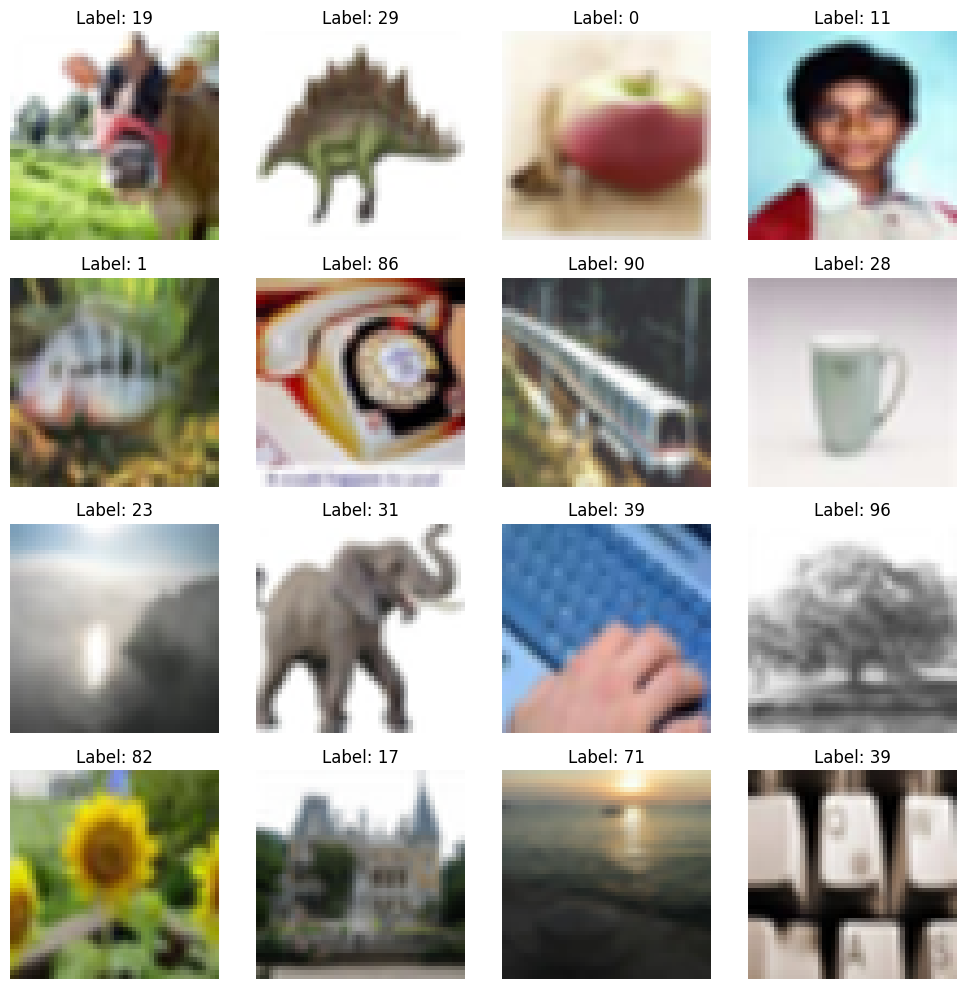

In [ ]:
# Aumentamos el tamaño de la imágenes a 48x48
new_train_images = []
new_test_images = []

for img in train_images:
  pil_img = Image.fromarray(np.array(img))
  resized = pil_img.resize((48, 48), Image.BICUBIC)
  resized = np.array(resized)

  new_train_images.append(resized)

new_train_images = np.array(new_train_images)

for img in test_images:
  pil_img = Image.fromarray(np.array(img))
  resized = pil_img.resize((48,48), Image.BICUBIC)
  resized = np.array(resized)

  new_test_images.append(resized)

new_test_images = np.array(new_test_images)


plt.figure(figsize=(10, 10))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(new_train_images[i])
  plt.title(f'Label: {train_fine_labels[i]}')
  plt.axis('off')

plt.tight_layout()
plt.show()

### Filtro para imágenes
Este tipo de filtro es conocido como un filtro de convolución o kernel, en concreto, es un filtro de realce de bordes o de nitidez. Es útil para realzar características distintivas y bordes en las imágenes, resalta detalles importantes que podrían facilitar la tarea de clasificación para un modelo de aprendizaje.
Los pesos negativos en los bordes acentúa la diferencia entre los píxeles adyacentes.

Aplicando este filtro, hemos conseguido una mayor precisión que con cualquier otro.

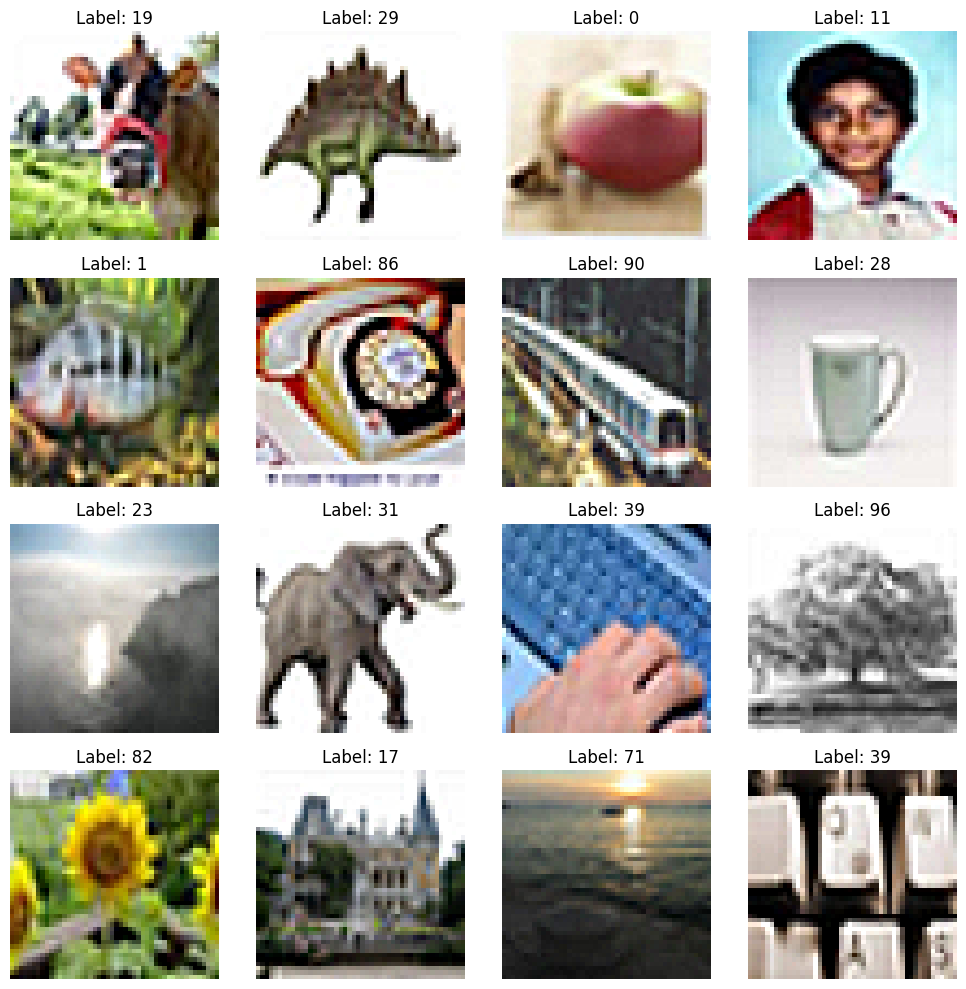

In [ ]:
# Afilamos las imágenes
for i in range(len(train_fine_labels)):
  new_train_images[i] = cv2.filter2D(new_train_images[i], -1, kernel=np.array([[0, -1, 0],
                                                        [-1, 5, -1],
                                                        [0, -1, 0]]))

for i in range(len(test_fine_labels)):
  new_test_images[i] = cv2.filter2D(new_test_images[i], -1, kernel=np.array([[0, -1, 0],
                                                        [-1, 5, -1],
                                                        [0, -1, 0]]))

plt.figure(figsize=(10, 10))

for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(new_train_images[i])
  plt.title(f'Label: {train_fine_labels[i]}')
  plt.axis('off')

plt.tight_layout()
plt.show()

## Definición del modelo final

Se realiza una mezcla aleatoria de las imágenes y sus respectivas etiquetas, utilizando permutaciones aleatorias de los índices originales. Seguidamente, se normalizan los valores de píxeles de las imágenes, dividiendo cada valor por 255.0, con el propósito de escalar los datos al rango [0, 1]. Posteriormente, se codifican las etiquetas en formato one-hot, una representación binaria que facilita la tarea de clasificación para el modelo. Además, se crea un conjunto de validación y un conjunto de entrenamiento parcial, separando las primeras 10000 imágenes y etiquetas para la validación y utilizando el resto para el entrenamiento parcial.

La mezcla aleatoria de las imágenes es una práctica esencial en el contexto de entrenamiento de modelos de redes neuronales convolucionales. Este procedimiento busca evitar posibles sesgos que podrían surgir si las imágenes se mantuvieran en un orden específico. La aleatorización de los datos de entrada contribuye a que el modelo no aprenda patrones basados en la secuencia de presentación, permitiendo una generalización más efectiva a datos no vistos. En el contexto de la visión por computadora, donde la posición y distribución de las imágenes pueden influir en el aprendizaje, la mezcla aleatoria promueve la robustez del modelo al presentarle variedad en el orden de las muestras. Este enfoque contrarresta la posibilidad de que el modelo memorice patrones espurios y favorece una adaptación más sólida a la diversidad intrínseca de las imágenes presentes en el conjunto de datos.

In [ ]:
# Se mezclan las imágenes para evitar complicaciones
num_train = new_train_images.shape[0]
num_test = new_test_images.shape[0]

# Para ello, se crean permutaciones de los índices actuales
train_indices = np.random.permutation(num_train)
test_indices = np.random.permutation(num_test)

# Se aplica sobre los datos
new_train_images = new_train_images[train_indices]
train_fine_labels = np.take(train_fine_labels, train_indices)

new_test_images = new_test_images[test_indices]
test_fine_labels = np.take(test_fine_labels, test_indices)

# Normalización
new_train_images = new_train_images.astype('float32') / 255.0
new_test_images = new_test_images.astype('float32') / 255.0

# Convertir las etiquetas a to categorical (one-hot encoding)
num_fine_classes = 100

train_fine_labels = to_categorical(train_fine_labels, num_fine_classes)
test_fine_labels = to_categorical(test_fine_labels, num_fine_classes)

val_images = new_train_images[:10000]
partial_train_images = new_train_images[10000:]

val_fine_labels = train_fine_labels[:10000]
partial_train_fine_labels = train_fine_labels[10000:]

La arquitectura del modelo escogido para el procesamiento de las imágenes se inspira en la red neuronal convolucional VGG-16, que ha mostrado ser muy eficiente en el reconocimiento de imágenes a gran escala.

En concreto, nuestro modelo se compone de tres bloques con dos capas convolucionales respectivamente. Las capas convolucionales de cada bloque comparten las mismas características, asignándole 64, 128 y 256 filtros de convolución a cada bloque. Asimismo, se emplea *Batch Normalization* para asegurar la estabilidad del modelo. Cada uno de los bloques finaliza con una capa *MaxPooling*, reduciendo el tamaño.

* **Función de activación:** La función de activación Exponential Linear Unit (ELU) es una función de activación parecida a  ReLU que evita el problema de saturación para valores positivos. *ELU* tiene una salida suave para valores negativos, lo que puede ayudar en la convergencia del entrenamiento ayudando en el proceso de retropropagación al tener un gradiente definido para entradas negativas.
En nuestro caso la función de activación `elu` ha demostrado mejorar el rendimiento de las redes neuronales en términos de velocidad de convergencia y rendimiento en el conjunto de datos Cifar100.
* **Kernel Regularizers:** La regularización L2 ayuda a controlar la complejidad del modelo al penalizar los pesos más grandes. Al limitar el tamaño de los pesos, la regularización L2 puede mejorar la capacidad del modelo para generalizar a datos no vistos. También promueve la selección de características más importantes y ayuda al modelo a generalizar mejor a datos no vistos. Como beneficio extra ayuda a estabilizar el proceso de entrenamiento, previniendo el sobreajuste, al evitar oscilaciones.
* **Padding:** Utilizar `padding=same` en una capa convolucional significa que se aplica un relleno a la entrada de la capa de manera que la salida tenga la misma altura y anchura que la entrada original.
Esto es beneficioso porque al aplicar convoluciones, especialmente con núcleos más grandes, la información en los bordes de la imagen de entrada puede perderse gradualmente a medida que la ventana de convolución se desplaza hacia el centro. El uso de `padding=same` ayuda a preservar la información en los bordes de la imagen original.
* **Batch Normalization y MaxPooling:** Utilizamos capas de normalización Batch después de las capas convolucionales para normalizar las activaciones y acelerar el entrenamiento. Luego, se aplican capas de MaxPooling para reducir la dimensionalidad espacial de las representaciones.
* **Capas densas:** Utilizamos capas densas para conectar las representaciones aprendidas por las capas convolucionales. Estas capas densas contienen neuronas completamente conectadas con funciones de activación 'elu' para introducir no linealidades en el modelo.
* **Dropout:** Cuando se aplica Dropout después de cada capa densa, significa que, durante el entrenamiento, aleatoriamente se establecen a cero algunas de las neuronas de la capa en cada iteración o lote de entrenamiento.
Al apagar aleatoriamente nodos durante el entrenamiento, la red se vuelve más robusta y menos propensa a depender de características específicas. Esto puede ayudar al modelo a adaptarse mejor a la variabilidad en los datos de entrada.
* **Capa de salida:** Utiliza una función de activación `softmax`, indicando el número de clases mediante `num_fine_classes`. Esto transforma las salidas de las capas anteriores en probabilidades que suman 1, facilitando la interpretación de la salida como una distribución de probabilidad sobre las clases.
* **Optimizador:** Se elige el optimizador *Adam* para el entrenamiento de la red neuronal debido a sus propiedades adaptativas y eficientes, que son muy útiles a la hora de trabajar con un conjunto grande de datos.

In [ ]:
# Función crear modelo
def build_model():
    model = models.Sequential()

    # Capas conovolucionales
    regularizers.l1(0.001)

    input_layer = layers.Input(shape=(48, 48, 3))
    conv1 = layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001),
                      padding='same', activation='elu')(input_layer)
    batch1 = layers.BatchNormalization()(conv1)
    conv11 = layers.Conv2D(64, (3, 3), padding='same', activation='elu')(batch1)
    batch11 = layers.BatchNormalization()(conv11)

    pool1 = layers.MaxPooling2D((2, 2))(batch11)

    conv2 = layers.Conv2D(128, (3, 3), padding='same', activation='elu')(pool1)
    batch2 = layers.BatchNormalization()(conv2)
    conv22 = layers.Conv2D(128, (3, 3), padding='same', activation='elu')(batch2)
    batch22 = layers.BatchNormalization()(conv22)

    pool2 = layers.MaxPooling2D((2, 2))(batch22)

    conv3 = layers.Conv2D(256, (3, 3), padding='same', activation='elu')(pool2)
    batch3 = layers.BatchNormalization()(conv3)
    conv33 = layers.Conv2D(256, (3, 3), padding='same', activation='elu')(batch3)
    batch33 = layers.BatchNormalization()(conv33)

    pool3 = layers.MaxPooling2D((2, 2))(batch33)

    flatten = layers.Flatten()(pool3)

    dense1 = layers.Dense(512, activation='elu')(flatten)
    batchd1 = layers.BatchNormalization()(dense1)
    drd1 = layers.Dropout(0.25)(batchd1)
    dense2 = layers.Dense(512, activation='elu')(drd1)
    batchd2 = layers.BatchNormalization()(dense2)
    drd2 = layers.Dropout(0.25)(batchd2)

    output_class = layers.Dense(num_fine_classes, activation='softmax', name='output_class')(drd2)

    model = models.Model(inputs=input_layer, outputs=output_class)

    # Compilación del modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics='accuracy')

    return model

In [ ]:
model = build_model()

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0   

La salida de la función summary proporciona tres categorías de parámetros:
1.	**Total params:** Es la cantidad total de parámetros en la red, tanto entrenables como no entrenables. Este número incluye todos los pesos y sesgos de las capas.
2.	**Trainable params:** Es la cantidad de parámetros que se ajustarán durante el entrenamiento del modelo. Esto incluye los pesos y sesgos de las capas que se actualizarán durante el proceso de optimización.
3.	**Non-trainable params:** Es la cantidad de parámetros que no se ajustarán durante el entrenamiento. Esto generalmente incluye parámetros de normalización por lotes, parámetros de activación y otros parámetros que no requieren actualizaciones durante el entrenamiento.


El total de parámetros se obtiene sumando los parámetros de todas las capas. En este caso, la suma es 6186148, y se muestra en la línea que indica "Total params". Además, se proporciona la cantidad de parámetros entrenables y no entrenables.

* La fórmula para calcular el número de parámetros en una capa convolucional es la siguiente:

  *Parámetros = (Tamaño del kernel × Tamaño del kernel × Canales de entrada + 1) × Canales de salida*

* La fórmula para calcular el número de parámetros en una capa totalmente conectada es la siguiente:

  *Parámetros = (Neuronas de entrada + 1) × Neuronas de salida*

* La fórmula general para calcular el número total de parámetros en una capa de Batch Normalization es:

  *Parámetros = 2 × C*

  Donde C es la cantidad de canales de entrada.
  La capa de Batch Normalization tiene dos tipos de parámetros por canal:

1. **Gamma (\(\gamma\)):**
   * Un parámetro de escala para ajustar la normalización.

2. **Beta (\(\beta\)):**
   * Un parámetro de sesgo para ajustar la normalización.

  Estos parámetros se aplican por canal, lo que lleva a C parámetros de gamma y C parámetros de beta.

  Es importante destacar que estos parámetros permiten que la capa de Batch Normalization aprenda cómo normalizar y ajustar las activaciones durante el entrenamiento, contribuyendo a la estabilidad y velocidad de convergencia de la red.


El número de parámetros en una red neuronal indica la complejidad de la red y su capacidad para aprender patrones. Un mayor número de parámetros puede permitir que la red capture representaciones más complejas, pero también puede aumentar el riesgo de sobreajuste si la cantidad de datos de entrenamiento es limitada. La regularización, como el dropout y la normalización por lotes (batch normalization), se utiliza en este caso para mitigar el sobreajuste.

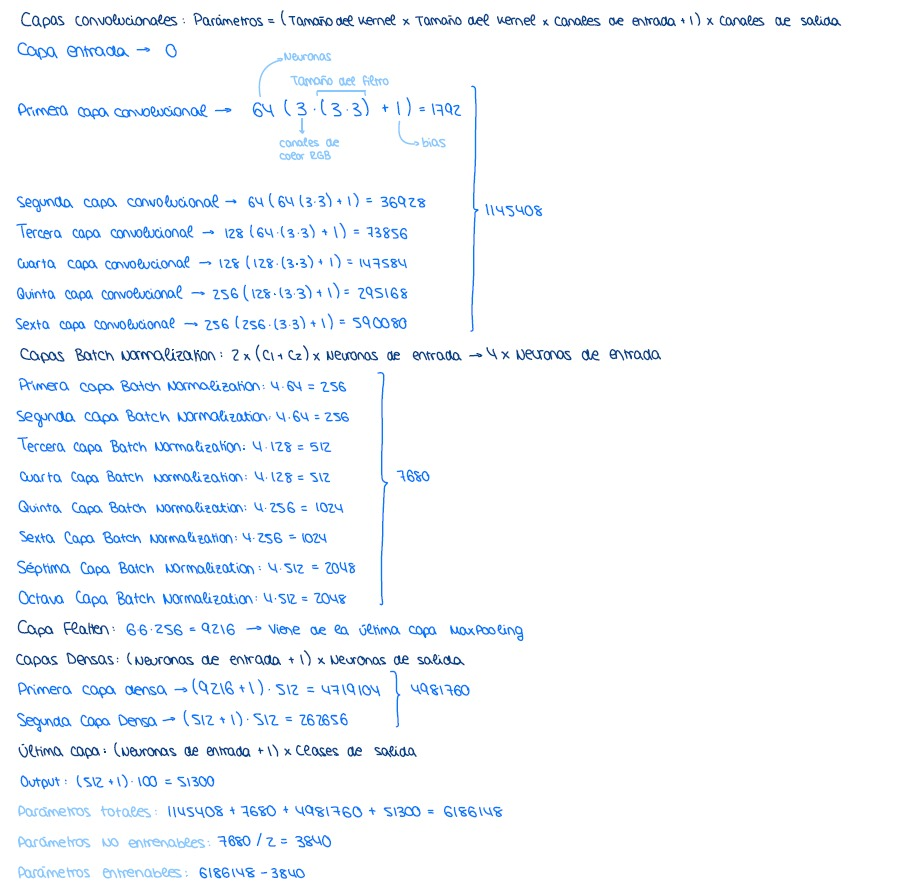

## Resultados

El callback tiene varias aportaciones bastante útiles, como, por ejemplo, detener la ejecución del modelo cuando, tras un número concreto de épocas no se observa mejora en la precisión o la pérdida aumenta.

En nuestro caso hemos decidido utilizar esta función para dos motivos específicos:

* Utilizamos un callback de `EarlyStopping` que monitorea la métrica de precisión en el conjunto de validación (`val_accuracy`). Si no hay mejora en la precisión durante 3 épocas consecutivas (`patience=3`), el entrenamiento se detendrá y se restaurarán los mejores pesos obtenidos.

* Utilizamos un callback de `LearningRateScheduler` que ajusta la tasa de aprendizaje durante el entrenamiento. En este caso, se mantiene constante hasta la época 9 y luego se reduce exponencialmente con el tiempo.

El modelo se entrena utilizando el método `fit.` Se utiliza el generador de flujo de datos `datagen.flow` para aplicar aumento de datos durante el entrenamiento. También se especifica la validación en el conjunto de datos de validación (`val_images, val_fine_labels`) y se incluyen los callbacks definidos anteriormente.


### Generador 'ImageDataGenerator'
El aumento de datos permite que el modelo vea variaciones de las imágenes originales durante el entrenamiento, lo cual ayuda a mejorar la capacidad de generalización del modelo. Al exponer la red a diferentes perspectivas, escalas y variaciones de las imágenes, se reduce la probabilidad de que el modelo memorice los datos de entrenamiento y que así aprenda patrones más robustos.

Para realizar aumentación de datos durante el entrenamiento de la red se utilizan los siguientes parámetros de ImageDataGenerator:
 * `rotation_range`: Rango de ángulos para rotación aleatoria de las imágenes.
 * `width_shift_range` y `height_shift_range`: Rangos de traslación horizontal y vertical, respectivamente.
 * `zoom_range`: Rango de zoom aleatorio.
 * `shear_range`: Rango de sesgado (deformación) aleatorio.
 * `horizontal_flip`: Volteo horizontal aleatorio.
 * `fill_mode`: Estrategia para llenar los píxeles después de aplicar transformaciones.

Los parámetros de ImageDataGenerator se aplican aleatoriamente durante el entrenamiento a cada imagen del conjunto de datos para introducir variabilidad.


In [ ]:
# Entrenamos el modelo
num_epochs = 60

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(partial_train_images)

# Callback Early Stopping
callback1 = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

# Callback Learning Rate
def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Entrenamiento del modelo
history = model.fit(datagen.flow(partial_train_images, partial_train_fine_labels, batch_size=128),
                    epochs=num_epochs, validation_data=(val_images, val_fine_labels), callbacks=[callback1, callback2])

# Evaluación del modelo
loss, class_accuracy= model.evaluate(new_test_images, test_fine_labels)

Epoch 1/60
313/313 [==============================] - 71s 170ms/step - loss: 3.9769 - accuracy: 0.1119 - val_loss: 4.4730 - val_accuracy: 0.0667 - lr: 0.0010
Epoch 2/60
313/313 [==============================] - 50s 158ms/step - loss: 3.2976 - accuracy: 0.2022 - val_loss: 3.0142 - val_accuracy: 0.2555 - lr: 0.0010
Epoch 3/60
313/313 [==============================] - 50s 161ms/step - loss: 2.9184 - accuracy: 0.2678 - val_loss: 2.5098 - val_accuracy: 0.3530 - lr: 0.0010
Epoch 4/60
313/313 [==============================] - 49s 157ms/step - loss: 2.6131 - accuracy: 0.3252 - val_loss: 2.2428 - val_accuracy: 0.4090 - lr: 0.0010
Epoch 5/60
313/313 [==============================] - 49s 157ms/step - loss: 2.3949 - accuracy: 0.3699 - val_loss: 2.1133 - val_accuracy: 0.4379 - lr: 0.0010
Epoch 6/60
313/313 [==============================] - 50s 160ms/step - loss: 2.2063 - accuracy: 0.4120 - val_loss: 2.2195 - val_accuracy: 0.4191 - lr: 0.0010
Epoch 7/60
313/313 [==============================] 

Nos sale un modelo con una precisión aproximada al **66%**

# Pruebas


### **INGENIERÍA DE CARACTERÍSTICAS**

### Detección de bordes con Sobel

Se define una función llamada `edge_detection` que toma una imagen como entrada y realiza operaciones de la conversión a escala de grises, la aplicación de un filtro de agudización y el uso del operador Sobel para calcular la magnitud del gradiente, generando así una imagen con los bordes resaltados.

La utilización del operador `Sobel` para la detección de bordes demostró limitaciones significativas en cuanto a la preservación de los colores originales de las fotografías. Esto derivó en que la precisión obtenida no alcanzó un nivel satisfactorio, quedando por debajo del umbral del 0.3 en el conjunto de test.

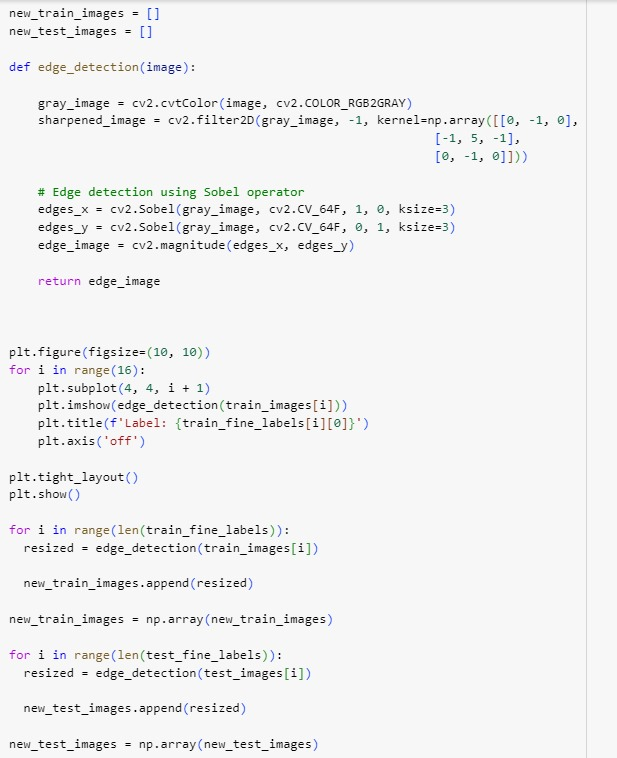

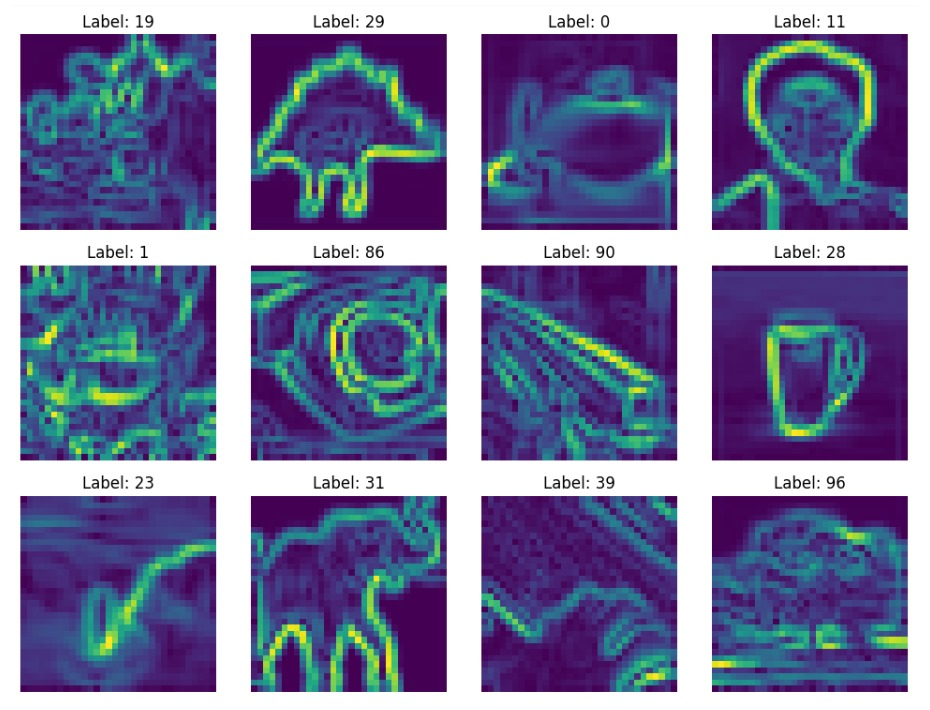

### Padding

Realizamos un preprocesamiento de las imágenes al expandir su tamaño mediante la adición de un margen. Lo hacemos de dos maneras y a continuación se describen los resultados:


*   Añadiendo padding en el modelo, con 10000 de validación y 20 épocas

    **Resultados**

   loss: 6.4618 - output_class_loss: 3.7764 - output_metaclass_loss: 2.6854 - output_class_accuracy: 0.3306 - output_metaclass_accuracy: 0.4384

*   Añadiendo padding manualmente a las imágenes (2,2), con 10000 de validación y 20 épocas

  Para llevar a cabo esta tarea, se define una función llamada `add_margin`. Esta función recibe dos parámetros: la imagen original a la que se le añadirá el margen y el tamaño deseado para el margen, especificado como una tupla `(pad_size_vertical, pad_size_horizontal)`. Utiliza la función `np.pad` de la biblioteca NumPy para realizar el agregado del margen, empleando el modo 'constant' para establecer valores constantes en el área de margen. Para cada imagen, se invoca la función `add_margin` con la imagen original y un tamaño de margen de (2,2). Las imágenes resultantes, ahora con el margen añadido, se almacenan en las listas `new_train_images` y `new_test_images`. Finalmente, estas listas se convierten en arrays de Numpy mediante `np.array`.

  **Resultados**

   loss: 6.0255 - output_class_loss: 3.5652 - output_metaclass_loss: 2.4603 - output_class_accuracy: 0.3267 - output_metaclass_accuracy: 0.4381

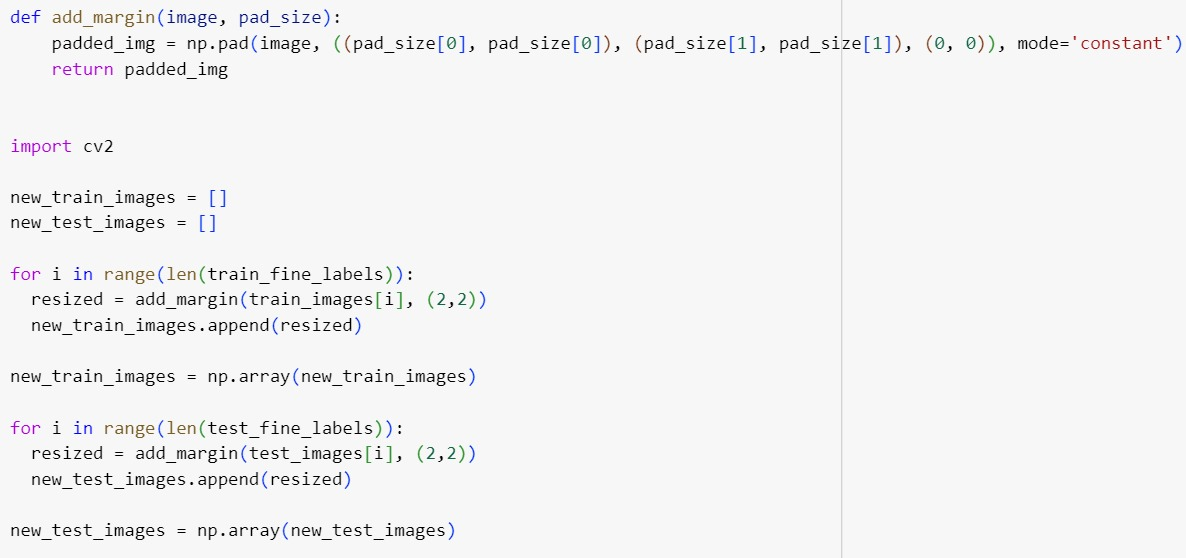

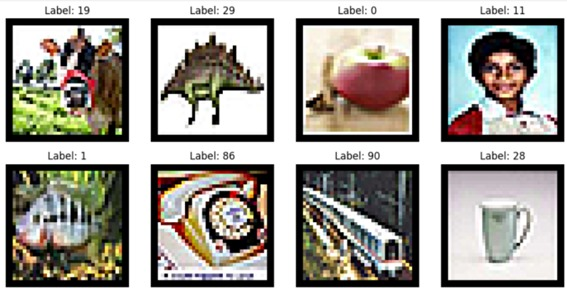

### Detección de Bordes con Canny
Se procesan las imágenes utilizando la biblioteca `OpenCV`. En primer lugar, aplicamos un filtro de agudización para resaltar detalles y bordes en cada imagen. Posteriormente, conviertimos las imágenes resultantes a escala de grises y aplicamos el algoritmo Canny para detectar bordes. Los parámetros utilizados son 50 y 150, que son los umbrales de intensidad para los bordes débiles y fuertes, respectivamente. Estos bordes se convierten nuevamente a formato RGB para su superposición a las imágenes originales. La superposición se realiza utilizando la función `cv2.addWeighted`, lo que crea una combinación ponderada de la imagen original y los bordes detectados. Este proceso busca resaltar y realzar características de borde en las imágenes, lo que puede ser beneficioso para mejorar la capacidad de un modelo de aprendizaje automático para reconocer patrones y detalles importantes durante el entrenamiento. Sin embargo, en nuestro caso no ha mejorado la precisión del modelo final, por lo que lo omitimos.

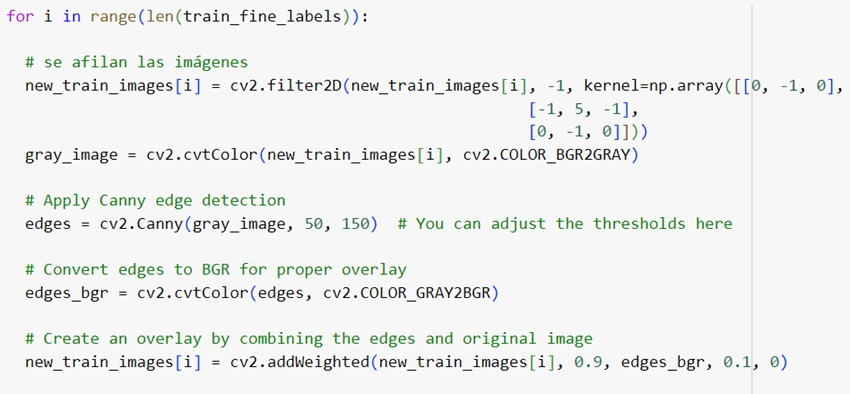
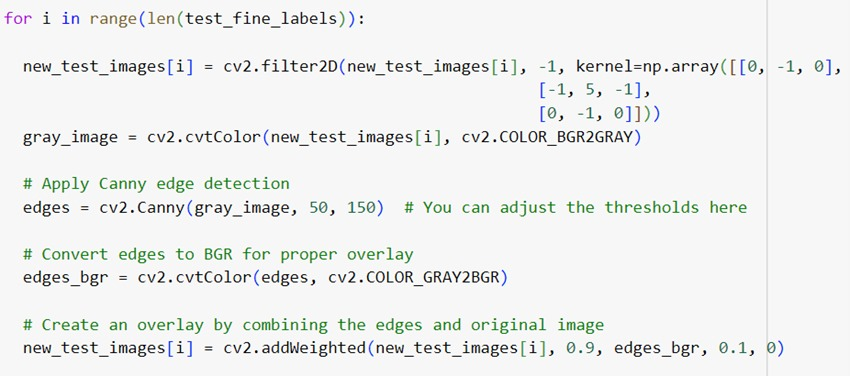
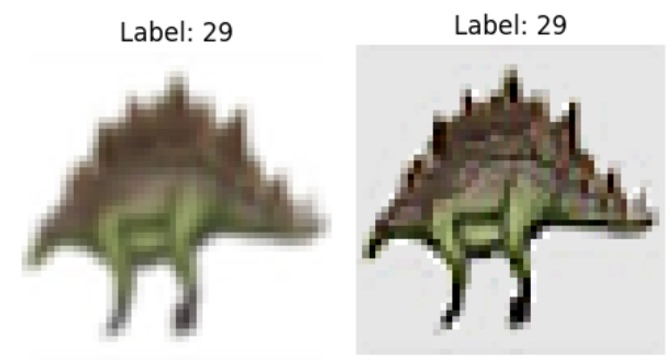

### Aumentación de datos
En un principio, implementábamos un proceso de aumentación de datos al introducir variaciones artificiales en las imágenes originales, buscando mejorar la capacidad de generalización del modelo, al exponerlo a una mayor diversidad de datos durante el entrenamiento.

 Para ello se creaban arrays vacíos para almacenar las nuevas imágenes y etiquetas resultantes del proceso de aumentación. Luego, se iteraba a través de las imágenes y etiquetas originales del conjunto de entrenamiento. Para cada imagen original, se añadía la imagen sin cambios al nuevo conjunto y se generaban tres variantes adicionales: una imagen con una rotación de 45 grados, otra obtenida al invertir horizontalmente la imagen original y la última invertida verticalmente. Estas nuevas imágenes se agregaban al array correspondiente, y las etiquetas asociadas a las nuevas imágenes se replicaban tres veces en el array de etiquetas.

Posteriormente, se conviertían las listas de imágenes y etiquetas generadas en arrays de Numpy para facilitar su manipulación y procesamiento. El mismo proceso se repetía para el conjunto de prueba, generando versiones aumentadas de cada imagen y sus respectivas etiquetas.

Con la implementación de este código hemos enfrentado problemas de agotamiento de la memoria RAM debido a la generación de múltiples variantes de imágenes y etiquetas. La replicación de datos y las transformaciones aplicadas resultan en conjuntos de datos significativamente más grandes, lo que nos ha llevado a una  falta de recursos y problemas de rendimiento.

Por ello hemos recurrido a la implementación del generador ImageDataGenerator, que no consume tanta memoria RAM porque no precalcula y almacena todas las imágenes aumentadas en la memoria antes de entrenar el modelo. En lugar de eso, aplica las transformaciones en tiempo real mientras se carga cada lote de imágenes durante el entrenamiento.

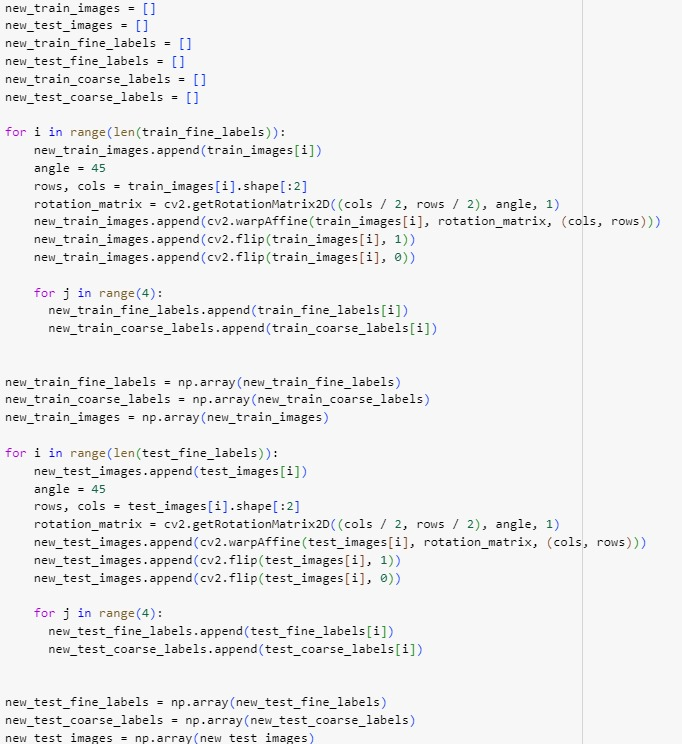

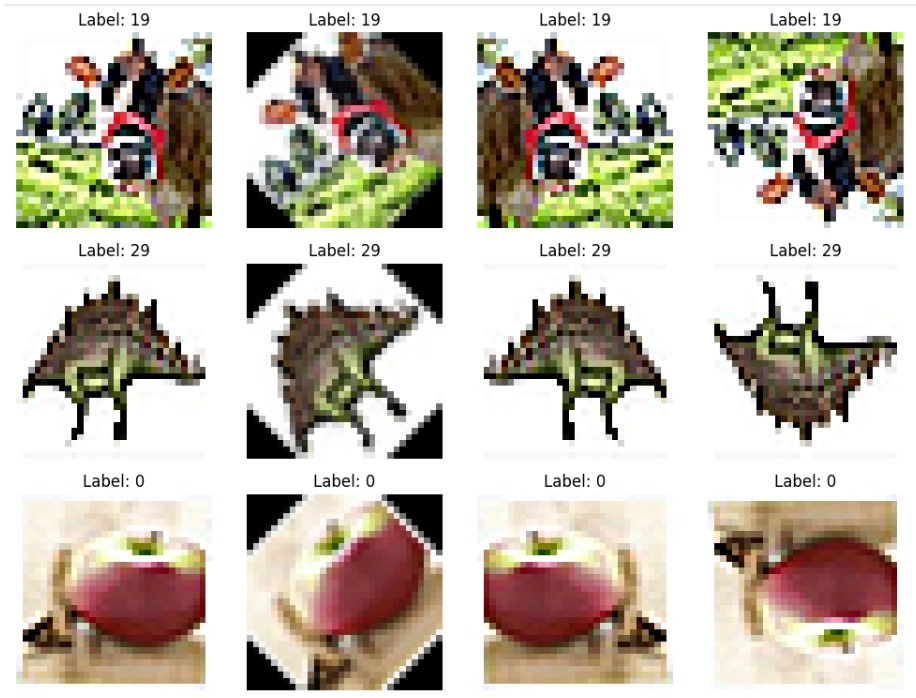

### Tamaño de las imágenes

Se muestra a continuación los resultados de la ejecución de las últimas épocas para un modelo igual al final, con la única diferencia de que la aumentación de imágenes se hace hasta el tamaño 64x64. Se puede observar que el tiempo que tarda en ejecutar es alrededor de 1 hora, el doble de lo que tarda con imágenes de 48x48. Como la precisión no aumenta con respecto al tiempo, descartamos el tamaño más grande y nos quedamos con la opción de aumentar cada imagen solo hasta 48x48 píxeles.

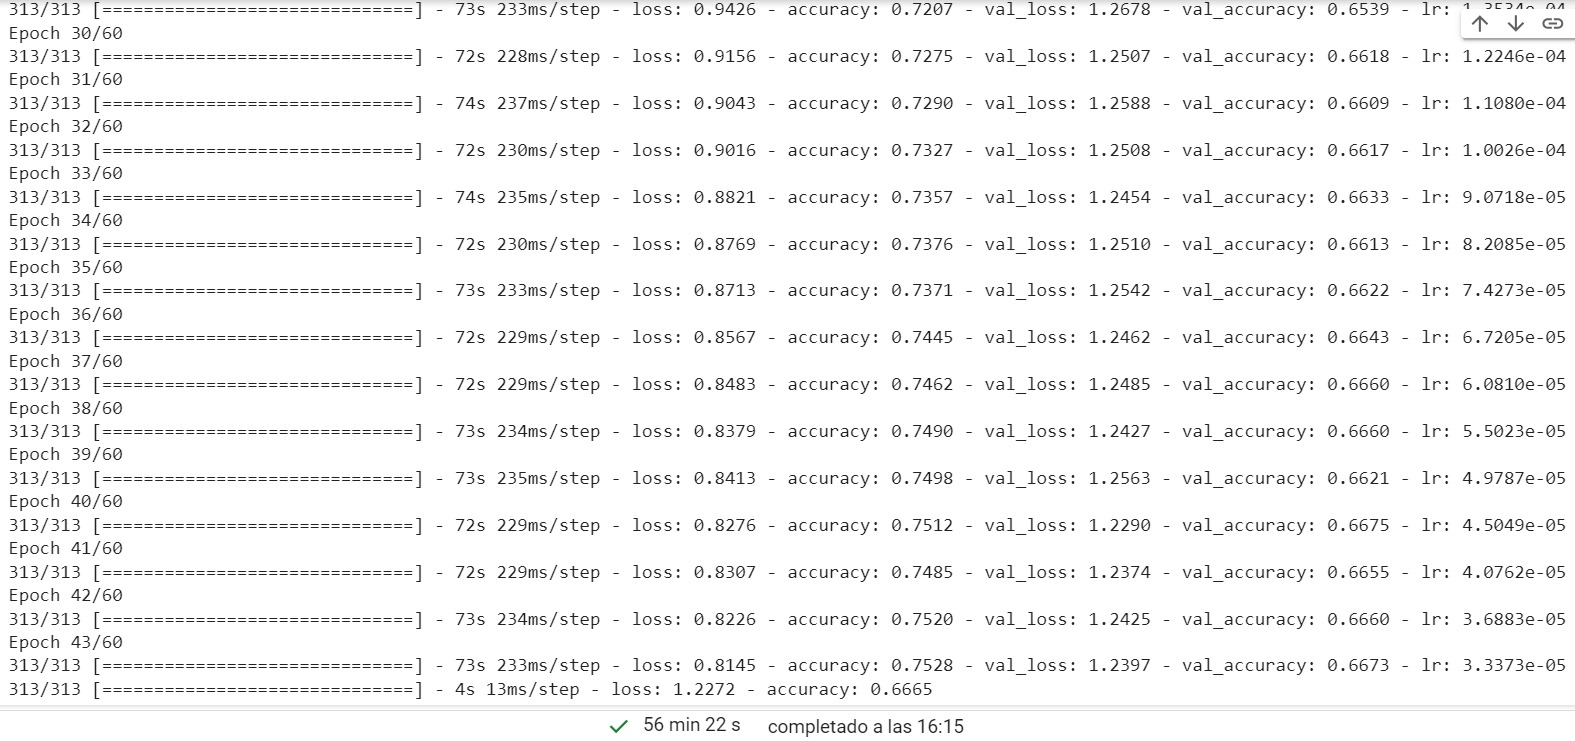

### **ARQUITECTURA DEL MODELO**


### Modelos con los que se han hecho las pruebas
Las pruebas de las que hemos estado hablando se han realizado en base a varios modelos diferentes.

**Modelo 1**

Este modelo es el más básico que hemos probado, con el objetivo de observar y analizar cómo los cambios  realizados mediante la ingeniería de características afectan a la precisión del modelo, es decir, si consigue clasificar mejor o no.

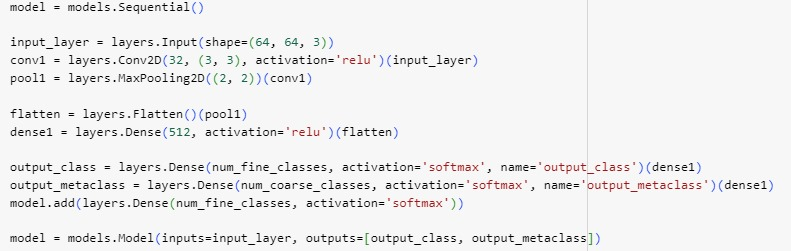

**Modelo 2**

Este modelo es más complejo que el anterior y lo vamos a utilizar para probar el padding y el dropout, y ajustar sus valores.

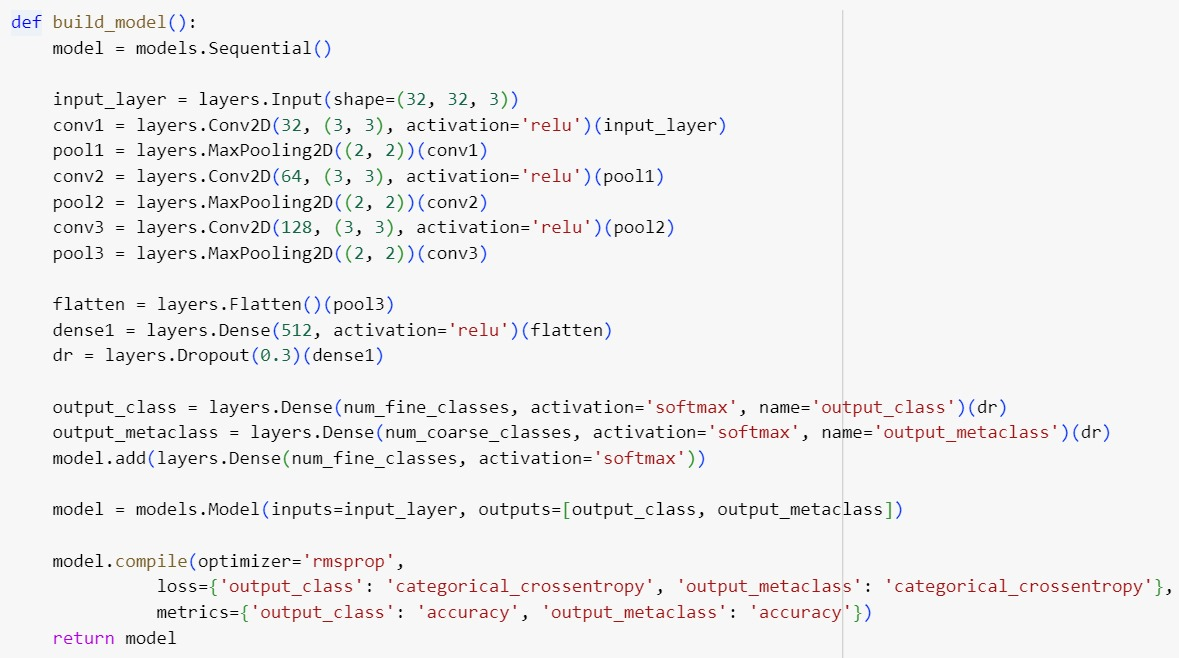

**Modelo 3:**

Este modelo es aún más complejo que el anterior y lo vamos a utilizar para hacer k iteraciones e interpolación BICUBIC.

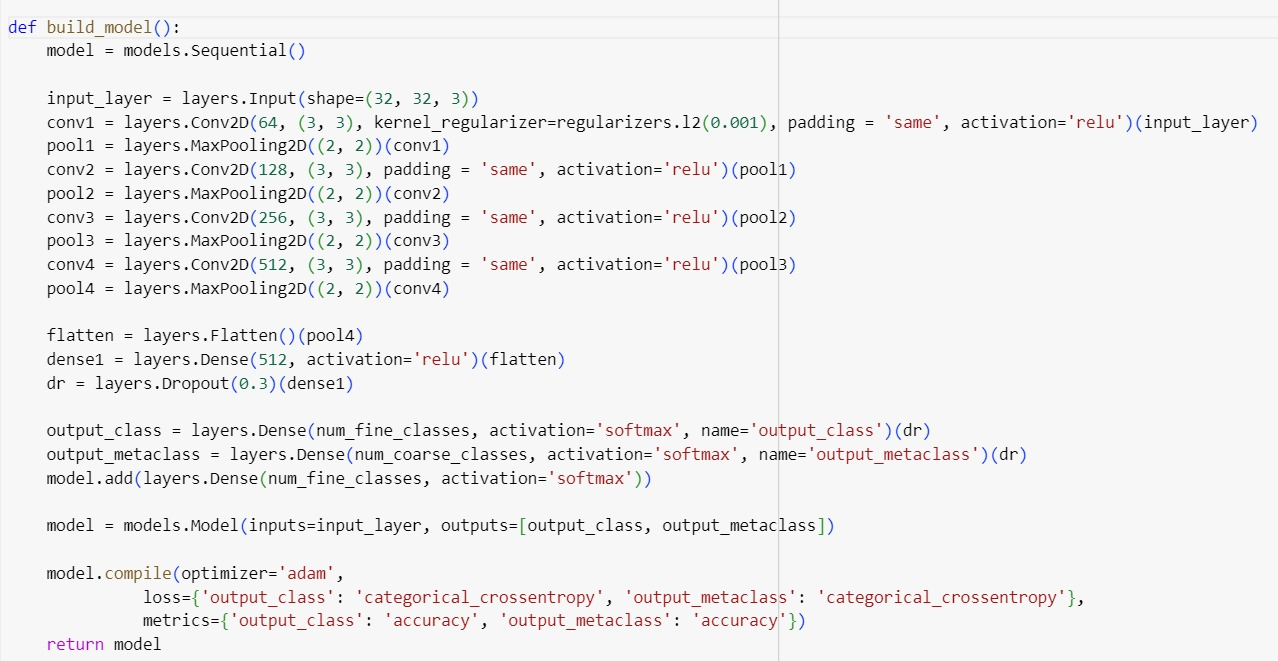

### Arquitectura VGG
VGG, una red neuronal convolucional diseñada para competir en el Desafío de Reconocimiento Visual a Gran Escala de ImageNet en 2014, logró una notable precisión del 92,7%, destacándose como uno de los modelos más exitosos en esa competición. Este logro representó un avance significativo al introducir núcleos de convolución más pequeños (3×3) en las capas convolucionales, marcando una mejora con respecto a los enfoques anteriores.

La arquitectura VGG ha demostrado su eficacia en la clasificación de imágenes, lo que motiva su replicación en diferentes contextos. Esta arquitectura se distingue por la profundidad de sus capas convolucionales y la utilización de filtros de tamaño reducido (3x3), con una stride de 1 en todas las capas convolucionales.

Para adaptar la arquitectura VGG al conjunto de datos CIFAR-100, es posible ajustar la estructura original para que se adecúe a las dimensiones específicas y al número de clases presentes en dicho conjunto de datos. Este proceso de adaptación permite aprovechar las características fundamentales de VGG en el contexto de CIFAR-100.

Al intentar replicarla nos hemos encontrado con varios problemas, el primero era el tiempo de ejecución y el segundo era que consumía una gran cantidad de RAM. Por lo que, este modelo solo lo hemos utilizado como inspiración para hacer uno más asequible para nuestra red de imágenes.

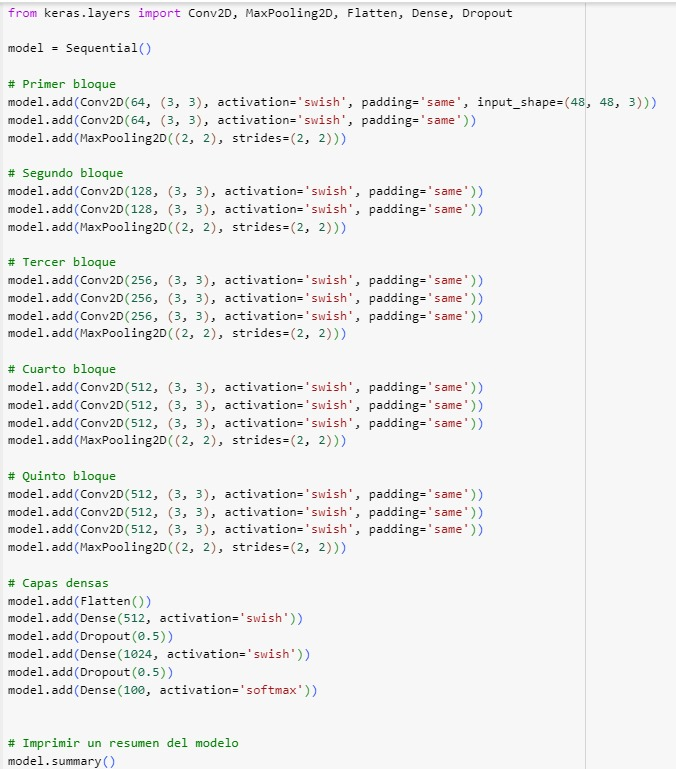

### K Iteraciones
Durante la fase de implementación de las iteraciones k en nuestro proceso, nos hemos enfrentado a un desafío significativo relacionado con el tiempo de ejecución. Se observó que el tiempo de ejecución aumentaba aproximadamente cinco veces en comparación con la ejecución sin estas iteraciones. Este aumento en el tiempo de procesamiento no proporcionaba beneficios considerables en términos de mejora de la precisión de nuestro modelo. En consecuencia, esta inversión adicional de recursos computacionales no se consideró rentable, ya que los beneficios obtenidos no justificaban el costo adicional en términos de tiempo de ejecución. Como resultado, hemos tomado la decisión de optimizar la eficiencia computacional y mantener un equilibrio entre el rendimiento del modelo y los recursos computacionales utilizados.

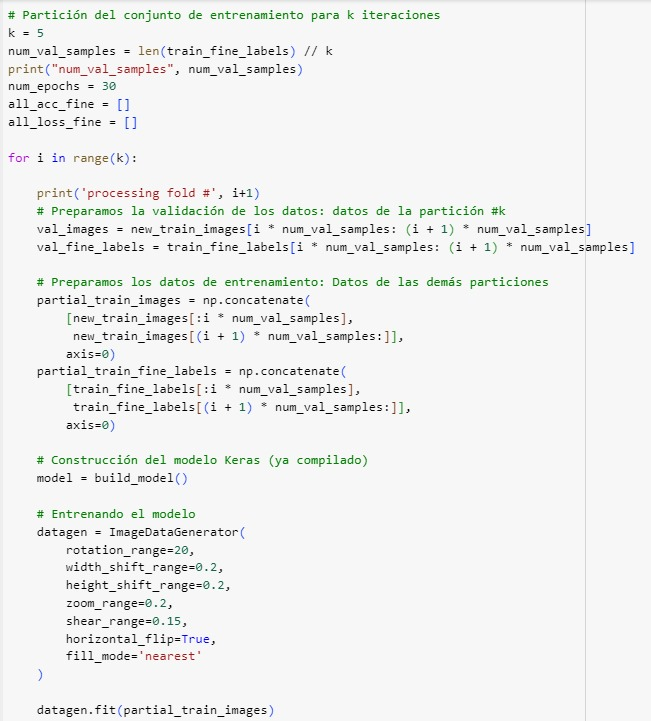

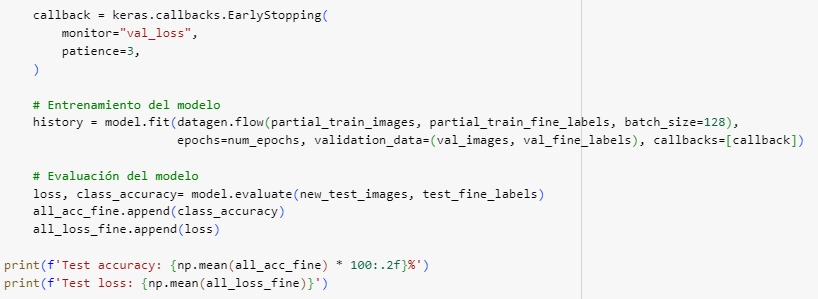

### Dropout
En el modelo 2:

Con dropout (0.4) e imágenes transformadas (sharp) con doble output:

loss: 3.9808 - output_class_loss: 2.3878 - output_metaclass_loss: 1.5930 - output_class_accuracy: 0.4344 - output_metaclass_accuracy: 0.5551

* Clases
 * Precisión: 43.44%
 * Pérdida: 2.3878
*Metaclases
 * Precisión: 55.51%
 * Pérdida: 1.5930

Con dropout (0.3) e imágenes transformadas (sharp) con doble output:

loss: 4.0400 - output_class_loss: 2.4191 - output_metaclass_loss: 1.6208 - output_class_accuracy: 0.4473 - output_metaclass_accuracy: 0.5647

* Clases
 * Precisión: 44.73%
 * Pérdida: 2.4191
*Metaclases
 * Precisión: 56.47%
 * Pérdida: 1.6208




###Interpolación BICUBIC, zoom, k interaciones
En el modelo 3

**Resultados sin k interaciones**

* Con 128 épocas sobre imágenes de 48x48 e interpolación BICUBIC + sharpening kernel [[0, -1, 0], [-1, 5, -1], [0, -1, 0]]  *(tarda unos 40s por época)*

 * sin zoom range y 20 épocas --> 53%

 * con zoom = 0.2 y 20 épocas (sobrentrenamiento) --> 53.8%

 * con zoom=0.2 y shear = 0.15 con 20 épocas -->54.32%

* Con 128 épocas sobre las imágenes de 64x64 con interpolación BICUBIC + sharpening kernel de siempre *(tarda alrededor de un minuto por época)*

 * con zoom=0.2 + shear_range=0.15 con 20 épocas --> 54.43%


**Resultados para k iteraciones**
* k = 5 + batch_size = 128 + con medida de val_loss y patience = 3 + sin batch normalization

 * Test accuracy: 50.90%
 * Test loss: 1.883827304840088

* k = 4 + batch_size = 128 + con medida de val_loss y patience = 3 + sin batch normalization

 * Test accuracy: 50.39%
 * Test loss: 1.9469149112701416

* k = 5 + batch_size = 128 + con medida de val_loss y patience = 3 + sin batch normalization + activation = 'swish'

 * Test accuracy: 54.39%
 * Test loss: 1.7578332424163818



## Conclusiones

La realización del trabajo expuesto en el documento ha puesto de relieve el importante papel que juega una arquitectura adecuada del modelo, capaz de procesar grandes conjuntos de datos que exigen una amplia clasificación. El empleo de herramientas que, dentro de la disparidad que supone trabajar sobre 100 clases distintas de imágenes, logren encontrar una vía estable de procesamiento resulta clave. Además, la correcta extracción de la información más representativa ha permitido reducir la cantidad de datos entre capas, optimizando el funcionamiento del modelo.

Bien si el preprocesamiento de imágenes ha estado enfocado en la computación de una resolución mayor que lograse destacar los trazados más característicos de las distintas clases de imágenes, se ha de resaltar las mejoras que la aplicación de la herramienta ImageDataGenerator ha traído al trabajo final. Ello se debe a que su funcionamiento parte de una idea muy intuitiva: el trazado y posición de los elementos que caracterizan cada clase no son fijos, sino que, al igual que el comportamiento de la naturaleza, presentan ligeras variaciones tanto en forma como orientación. Así, se puede confirmar el origen de las redes convolucionales en el comportamiento de las neuronas en la corteza visual de un cerebro humano.

También, se ha de mencionar la posibilidad de mejoras futuras que el modelo podría admitir de disponer de una mayor capacidad de memoria o herramientas externas al directorio de trabajo enfocadas a este tipo de cuestiones.

Por último, en cuanto al trabajo en equipo, como en las prácticas anteriores, todas hemos colaborado en todas las partes: pruebas, modelo final y realización de la memoria. El mayor reto sin ninguna duda ha sido ser capaces de buscar, entender, aplicar y seleccionar el mejor código posible que hemos llegado a alcanzar.
